# 本実装前のテストスクリプト

## sin形状の経路生成

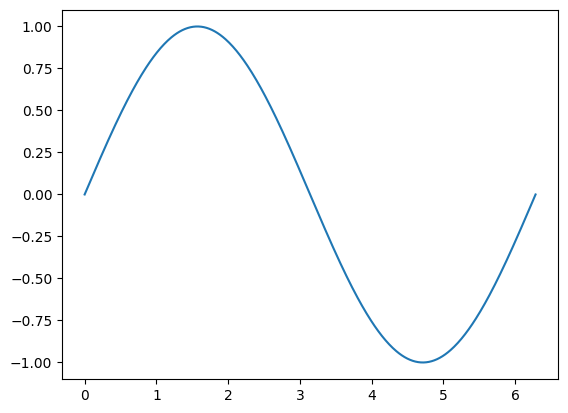

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def sin_curve() -> np.ndarray:
    x = np.linspace(0, 2*np.pi, 500)
    y = np.sin(x)
    path = np.c_[x, y]
    return path

path = sin_curve()
plt.plot(path[:, 0], path[:, 1])
plt.show()

## ロボットの現在位置のインデックスを算出

In [31]:
def calc_index(current_pose: np.ndarray, path: np.ndarray) -> np.intp:
    # current_pose: [x, y, theta]
    # ロボットの位置と、経路上の各位置間の距離を計算し、最も近い位置のインデックスを返す
    distances = np.linalg.norm(path[:, :2] - current_pose[:2], axis=1)
    idx = np.argmin(distances)
    
    return idx

動作確認→OK

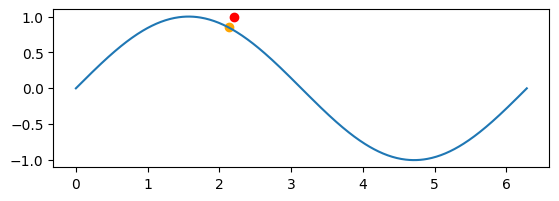

In [32]:
current_pose = np.array([2.2, 1.0, 0.0])
current_idx = calc_index(current_pose, path)

# 描画して確認
fig = plt.figure()
ax = fig.subplots()
ax.plot(path[:, 0], path[:, 1])
ax.scatter(path[current_idx, 0], path[current_idx, 1], c='orange')
ax.scatter(current_pose[0], current_pose[1], c='red')
ax.set_aspect('equal')
plt.show()

## 前方注視距離の算出、前方注視点の計算、前方注視点までの曲率

経路の各位置までの距離の算出

素朴バージョン

In [33]:
slow_path_distances = [0.0]
for i in range(len(path)-1):
    distance = float(np.linalg.norm(path[i+1] - path[i]))
    path_distance = slow_path_distances[-1] + distance
    slow_path_distances.append(path_distance)

高速化バージョン

In [34]:
# 点間の差を計算
differences = np.diff(path, axis=0)

# 各差のノルム（距離）を計算
distances = np.linalg.norm(differences, axis=1)

# 累積距離を計算
path_distances = np.concatenate(([0.0], np.cumsum(distances)))

テスト

In [35]:
if np.array_equal(slow_path_distances, path_distances):
    print("OK!")

OK!


In [38]:
import math

static_look_ahead_distance = 0.5

def calc_path_distances(path: np.ndarray) -> np.ndarray:
    # 経路の距離の累積和を計算
    ## 点間の差を計算
    differences = np.diff(path, axis=0)
    ## 各差のノルム（距離）を計算
    distances = np.linalg.norm(differences, axis=1)
    ## 累積距離を計算
    path_distances = np.concatenate(([0.0], np.cumsum(distances)))
    
    return path_distances

def calc_look_ahead_distance(current_velocity: np.ndarray) -> float:
    # calc look ahead distance
    look_ahead_distance = static_look_ahead_distance + max((current_velocity[0] - 0.5), 0.0)
    return look_ahead_distance

def calc_curvature_to_look_ahead_position(current_pose: np.ndarray, current_idx: np.intp, path: np.ndarray, path_distances: np.ndarray, look_ahead_distance: float ) -> tuple[float, np.ndarray]:
    # 前方注視点の位置を計算
    ## 現在位置の距離を取得
    current_distance = path_distances[current_idx]
    ## 前方注視点の距離を計算
    look_ahead_pos_distance = current_distance + look_ahead_distance
    ## 前方注視点のインデックスを取得
    look_ahead_idx = np.searchsorted(path_distances, look_ahead_pos_distance)
    ## 前方注視点の位置を取得
    look_ahead_pos = path[look_ahead_idx]
    
    # 曲率を計算
    ## 前方注視点に向けた角度を計算
    look_ahead_angle = (math.atan2(look_ahead_pos[1] - current_pose[1], look_ahead_pos[0] - current_pose[0]) - current_pose[2])
    ## 前方注視点までの距離を計算
    L = float(np.linalg.norm(look_ahead_pos - current_pose[:2]))
    ## 曲率を計算
    curvature = 2.0 * math.sin(look_ahead_angle) / L
    
    return curvature, look_ahead_pos

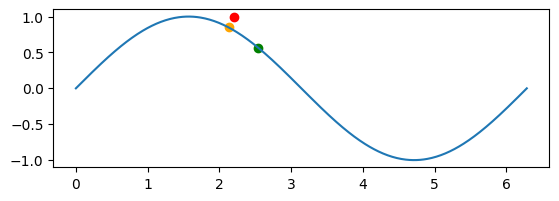

In [46]:
current_velocity = np.array([0.5, 0.0])
static_look_ahead_distance = 0.5

path_distances = calc_path_distances(path)
look_ahead_distance = calc_look_ahead_distance(current_velocity)
curvature, look_ahead_pos = calc_curvature_to_look_ahead_position(current_pose, current_idx, path, path_distances, look_ahead_distance)

# 描画して確認
fig = plt.figure()
ax = fig.subplots()
ax.plot(path[:, 0], path[:, 1])
ax.scatter(path[current_idx, 0], path[current_idx, 1], c='orange')
ax.scatter(current_pose[0], current_pose[1], c='red')
ax.scatter(look_ahead_pos[0], look_ahead_pos[1], c='green')
ax.set_aspect('equal')
plt.show()

## 加減速の決定

In [49]:
STATIC_LOOK_AHEAD_DISTANCE = 0.5
V_MAX = 0.5
V_MIN = 0.0
W_MAX = 1.0
W_MIN = -1.0
A_MAX = 0.5
AW_MAX = 1.0
DT = 0.1

def decide_accel_or_decel(current_idx: np.intp, path_distances: np.ndarray) -> bool:
    # 経路のゴールまでの距離を計算
    goal_distance = path_distances[-1] - path_distances[current_idx]
    
    # 制動距離を計算
    decel_distance = (V_MAX ** 2) / (2 * A_MAX)
    
    # ゴール距離が制動距離よりも長い場合、加速
    if goal_distance > decel_distance:
        return True
    else:
        return False


## Dynamic Windowの計算と、最適な速度の算出

素朴なコード

In [61]:
def calc_optimal_velocity_considering_dynamic_window(current_velocity: np.ndarray, curvature: float, is_accel: bool) -> np.ndarray:
    # dynamic windowを作る
    dw_vmax = min(current_velocity[0] + A_MAX * DT, V_MAX)
    dw_vmin = max(current_velocity[0] - A_MAX * DT, V_MIN)
    dw_wmax = min(current_velocity[1] + AW_MAX * DT, W_MAX)
    dw_wmin = max(current_velocity[1] - AW_MAX * DT, W_MIN)
    
    # Dynamic windowと曲率直線の交点を計算
    ## DWの4辺との交点を算出（解析解を代入）
    velocity_candidates = []
    p1 = (dw_vmin, curvature * dw_vmin)
    p2 = (dw_vmax, curvature * dw_vmax)
    velocity_candidates.append(p1)
    velocity_candidates.append(p2)
    if curvature != 0.0:
        p3 = (dw_wmin / curvature, dw_wmin)
        p4 = (dw_wmax / curvature, dw_wmax)
        velocity_candidates.append(p3)
        velocity_candidates.append(p4)
    ## 交点がDWの範囲内にあるか確認
    valid_velocity_candidates = []
    for v in velocity_candidates:
        if dw_vmin <= v[0] <= dw_vmax and dw_wmin <= v[1] <= dw_wmax:
            valid_velocity_candidates.append(v)
    
    # 最適な速度を計算
    ## 交点がある場合
    if len(valid_velocity_candidates) > 0:
        # 加速減速に基づいて目標速度を決める
        # 並進速度でソートする
        valid_velocity_candidates.sort(key=lambda x: x[0])
        # 加速する場合は、最も早い速度を選択
        if is_accel:
            next_velocity = valid_velocity_candidates[-1]
        # 減速する場合は、最も遅い速度を選択
        else:
            next_velocity = valid_velocity_candidates[0]
    
    ## 交点がない場合
    else:
        # 4頂点との距離を計算（距離関数は凸関数で、長方形は凸領域であることから、極値は4頂点上でとる）
        distance_from_coords = []
        dw_coords = [
            (dw_vmin, dw_wmin),
            (dw_vmin, dw_wmax),
            (dw_vmax, dw_wmin),
            (dw_vmax, dw_wmax),
        ]
        for p in dw_coords:
            # 曲率直線から頂点までの距離を算出
            dist = abs(curvature * p[0] - p[1]) / math.sqrt(curvature**2 + 1)
            distance_from_coords.append(dist)
        
        # 最短距離を見つける
        min_dist = min(distance_from_coords)
        # 最短距離となる速度候補のリストを作る
        min_dist_dw_coords = []
        for p, dist in zip(dw_coords, distance_from_coords):
            if dist == min_dist:
                min_dist_dw_coords.append(p)
        # 最短距離となる速度候補のリストを並進速度でソート
        min_dist_dw_coords.sort(key=lambda x: x[0])
        # 加速する場合は、最も早い速度を選択
        if is_accel:
            next_velocity = min_dist_dw_coords[-1]
        # 減速する場合は、最も遅い速度を選択
        else:
            next_velocity = min_dist_dw_coords[0]
    
    return np.array(next_velocity)

高速化したコード

In [62]:
def calc_optimal_velocity_considering_dynamic_window_fast(current_velocity: np.ndarray, curvature: float, is_accel: bool) -> np.ndarray:
    # dynamic windowを作る
    dw_vmax = min(current_velocity[0] + A_MAX * DT, V_MAX)
    dw_vmin = max(current_velocity[0] - A_MAX * DT, V_MIN)
    dw_wmax = min(current_velocity[1] + AW_MAX * DT, W_MAX)
    dw_wmin = max(current_velocity[1] - AW_MAX * DT, W_MIN)
    
    # Dynamic windowと曲率直線の交点を計算
    velocity_candidates = np.array([
        [dw_vmin, curvature * dw_vmin],
        [dw_vmax, curvature * dw_vmax]
    ])
    if curvature != 0.0:
        p3 = np.array([dw_wmin / curvature, dw_wmin])
        p4 = np.array([dw_wmax / curvature, dw_wmax])
        velocity_candidates = np.vstack((velocity_candidates, p3, p4))
    
    # 交点がDWの範囲内にあるか確認
    v0 = velocity_candidates[:, 0]
    v1 = velocity_candidates[:, 1]
    valid_mask = (dw_vmin <= v0) & (v0 <= dw_vmax) & (dw_wmin <= v1) & (v1 <= dw_wmax)
    valid_velocity_candidates = velocity_candidates[valid_mask]
    
    # 最適な速度を計算
    if valid_velocity_candidates.shape[0] > 0:
        if is_accel:
            next_velocity = valid_velocity_candidates[np.argmax(valid_velocity_candidates[:, 0])]
        else:
            next_velocity = valid_velocity_candidates[np.argmin(valid_velocity_candidates[:, 0])]
    else:
        # 4頂点との距離を計算
        dw_coords = np.array([
            [dw_vmin, dw_wmin],
            [dw_vmin, dw_wmax],
            [dw_vmax, dw_wmin],
            [dw_vmax, dw_wmax],
        ])
        p0 = dw_coords[:, 0]
        p1 = dw_coords[:, 1]
        denom = np.hypot(curvature, 1)
        distances = np.abs(curvature * p0 - p1) / denom
        
        min_dist = np.min(distances)
        min_indices = np.where(distances == min_dist)[0]
        min_dist_dw_coords = dw_coords[min_indices]
        
        if is_accel:
            next_velocity = min_dist_dw_coords[np.argmax(min_dist_dw_coords[:, 0])]
        else:
            next_velocity = min_dist_dw_coords[np.argmin(min_dist_dw_coords[:, 0])]
    
    return next_velocity

検証

In [64]:
from time import perf_counter

is_accel = decide_accel_or_decel(current_idx, path_distances)

start = perf_counter()
next_vel = calc_optimal_velocity_considering_dynamic_window(current_velocity, curvature, is_accel)
end = perf_counter()
print(f"previous implementation: {end - start}")

start = perf_counter()
next_vel_fast = calc_optimal_velocity_considering_dynamic_window_fast(current_velocity, curvature, is_accel)
end = perf_counter()
print(f"new fast implementation: {end - start}")

if np.allclose(next_vel, next_vel_fast):
    print("OK!")

previous implementation: 4.003100002591964e-05
new fast implementation: 0.00012234899986651726
OK!


以前の実装のほうが早いやんけ、以前のを使います。

ここまでで、dwpの実装は完了。
dwp.pyに実装をまとめる。

# ロボットのシミュレータの作成

差動二輪ロボットのforward simulationを実装する。

In [1]:
import numpy as np

def forward_simulation_differential(current_pose: np.ndarray, next_velocity: np.ndarray) -> np.ndarray:
    if next_velocity[1] == 0.0:
        # 直進運動
        next_pose = current_pose + np.array([
            next_velocity[0] * np.cos(current_pose[2]),
            next_velocity[0] * np.sin(current_pose[2]),
            next_velocity[1]
        ]) * DT
    else:
        # 旋回運動
        R = next_velocity[0] / next_velocity[1]
        next_pose = current_pose + np.array([
            R * (np.sin(current_pose[2] + next_velocity[1] * DT) - np.sin(current_pose[2])),
            R * (-np.cos(current_pose[2] + next_velocity[1] * DT) + np.cos(current_pose[2])),
            next_velocity[1] * DT
        ])
    
    return next_pose
    

In [50]:
%load_ext autoreload
%autoreload 2
from dwp import dwp
from path import sin_curve
from time import perf_counter
from config import DT

# 初期設定
## ロボットの状態
current_pose = np.array([0.0, 0.0, np.pi / 2])
current_velocity = np.array([0.0, 0.0])

## 経路
path = sin_curve()

# データの保存
robot_poses = [current_pose]
robot_velocities = [current_velocity]
look_ahead_positions = []

# シミュレーション
sim_start_time = perf_counter()
while True:
    # 終了条件
    if np.linalg.norm(current_pose[:2] - path[-1]) < 0.01:
        break
    
    next_velocity, look_ahead_pos = dwp(current_pose, current_velocity, path)
    next_pose = forward_simulation_differential(current_pose, next_velocity)
    
    current_pose = next_pose
    current_velocity = next_velocity
    
    robot_poses.append(current_pose)
    robot_velocities.append(current_velocity)
    look_ahead_positions.append(look_ahead_pos)
sim_end_time = perf_counter()
print(f"Simulation time: {sim_end_time - sim_start_time}s")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Simulation time: 0.007796584999596234s


アニメーションの描画

In [33]:
len(robot_poses)

159

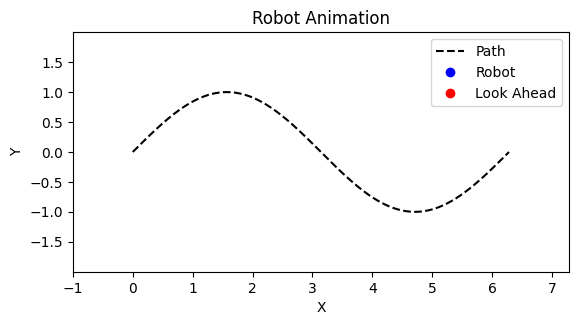

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch

# データの変換
robot_poses = np.array(robot_poses)
look_ahead_positions = np.array(look_ahead_positions)
path = np.array(path)

fig, ax = plt.subplots()
ax.set_xlim(np.min(path[:, 0]) - 1, np.max(path[:, 0]) + 1)
ax.set_ylim(np.min(path[:, 1]) - 1, np.max(path[:, 1]) + 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Robot Animation')
ax.set_aspect('equal')

# プロット要素の初期化
path_line, = ax.plot(path[:, 0], path[:, 1], 'k--', label='Path')  # パス
robot_point, = ax.plot([], [], 'bo', label='Robot')  # ロボット位置
look_ahead_point, = ax.plot([], [], 'ro', label='Look Ahead')  # ルックアヘッド位置

# ロボットの向きを示す矢印
robot_arrow = FancyArrowPatch((0, 0), (0, 0), mutation_scale=20, color='blue')
ax.add_patch(robot_arrow)

def init():
    robot_point.set_data([], [])
    look_ahead_point.set_data([], [])
    robot_arrow.set_visible(False)
    return path_line, robot_point, look_ahead_point, robot_arrow

def update(frame):
    # ロボットの位置を更新
    robot_x = robot_poses[frame, 0]
    robot_y = robot_poses[frame, 1]
    robot_theta = robot_poses[frame, 2]

    robot_point.set_data([robot_x], [robot_y])

    # ロボットの向きを示す矢印を更新
    arrow_length = 0.5  # 矢印の長さ
    dx = arrow_length * np.cos(robot_theta)
    dy = arrow_length * np.sin(robot_theta)

    # 矢印の位置を更新
    robot_arrow.set_positions((robot_x, robot_y), (robot_x + dx, robot_y + dy))
    robot_arrow.set_visible(True)

    # ルックアヘッドの位置を更新
    if frame < len(robot_poses) - 1:
        look_ahead_x = look_ahead_positions[frame, 0]
        look_ahead_y = look_ahead_positions[frame, 1]
        look_ahead_point.set_data([look_ahead_x], [look_ahead_y])
    else:
        look_ahead_point.set_data([], [])

    return path_line, robot_point, look_ahead_point, robot_arrow

ani = FuncAnimation(
    fig, update, frames=len(robot_poses), init_func=init, blit=False, interval=100, repeat=False
)

# 凡例を表示
ax.legend()

# アニメーションを表示または保存
# plt.show()
ani.save('robot_animation.mp4', writer='ffmpeg', fps=10)


In [28]:
len(path)

500

# 経路を複数生成

In [6]:
import numpy as np

def sin_curves() -> list:
    paths = []
    
    x = np.linspace(0, 2*np.pi, 500)
    
    # y = a*sin(bx)
    a_list = [0.5, 1.0, 1.5]
    b_list = [1.0, 2.0 ,3.0]
    
    for a in a_list:
        for b in b_list:
            y = a * np.sin(b * x)
            path = np.c_[x, y]
            paths.append(path)
            
    return paths

def step_curves() -> list:
    
    paths = []
    
    theta_list = [np.pi/4, np.pi/2, 3*np.pi/4]
    l_list = [1.0, 2.0, 3.0]
    
    for theta in theta_list:
        for l in l_list:
            # section 1
            x1 = np.linspace(0, 1, 100)
            y1 = np.zeros_like(x1)
            
            # section 2
            x2 = np.linspace(1.0, 1.0+l*math.cos(theta), 100)
            y2 = np.linspace(0.0, l*math.sin(theta), 100)
            
            # section 3
            x3 = np.linspace(1.0+l*math.cos(theta), 4.0+l*math.cos(theta), 100)
            y3 = np.ones_like(x3) * l * math.sin(theta)
            
            x = np.concatenate([x1, x2, x3])
            y = np.concatenate([y1, y2, y3])
            path = np.c_[x, y]
            paths.append(path)
    
    return paths



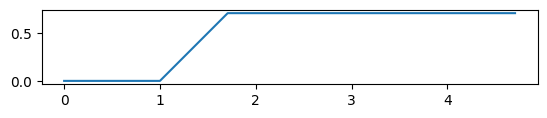

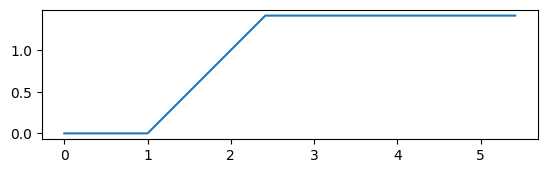

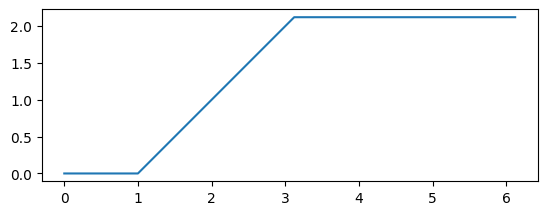

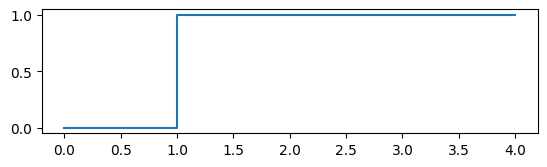

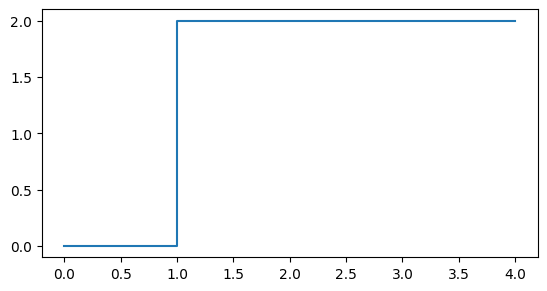

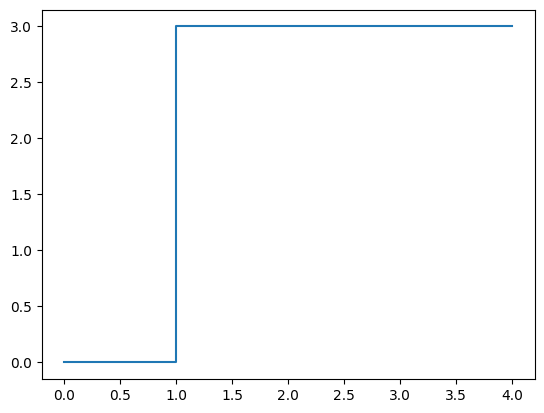

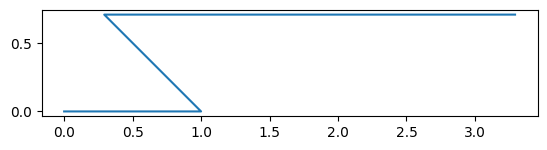

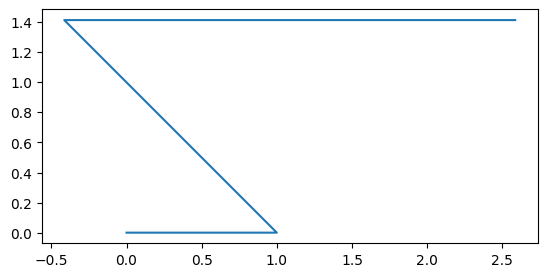

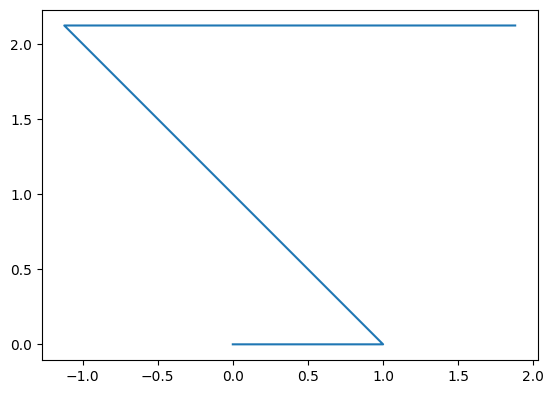

In [7]:

sin_paths = step_curves()
from matplotlib import pyplot as plt
for sin_path in sin_paths:
    fig = plt.figure()
    ax = fig.subplots()
    ax.plot(sin_path[:, 0], sin_path[:, 1])
    ax.set_aspect('equal')
    plt.show()
    